# Plot PyPI download stats

## Download the data

You can download the data using the free Google Cloud BigQuery Sandbox APIs.

1. Set up a BiyQuery Sanbdox account following these instructions: https://cloud.google.com/bigquery/docs/sandbox.
2. Use the online console to run the query (before running the query you can see a preview of the usage in the top right). You have 10 TB of free queries per month. This is the query used shown in the screenshot (documentation here https://packaging.python.org/en/latest/guides/analyzing-pypi-package-downloads/).
```sql
#standardSQL
SELECT
  file.project AS project,
  COUNT(*) AS num_downloads,
  DATE_TRUNC(DATE(timestamp), WEEK(MONDAY)) AS `week`
FROM `bigquery-public-data.pypi.file_downloads`
WHERE
  file.project IN ('spatialdata', 'muon', 'mudata', 'mofapy2', 'anndata', 'cell2location')
  -- Only query the last 5 years of history
  AND DATE(timestamp)
    BETWEEN DATE_TRUNC(DATE_SUB(CURRENT_DATE(), INTERVAL 5 YEAR), WEEK(MONDAY))
    AND CURRENT_DATE()
GROUP BY project, `week`
ORDER BY `week` DESC, project

```

3. Download the data as a CSV file, here called `data.csv`.

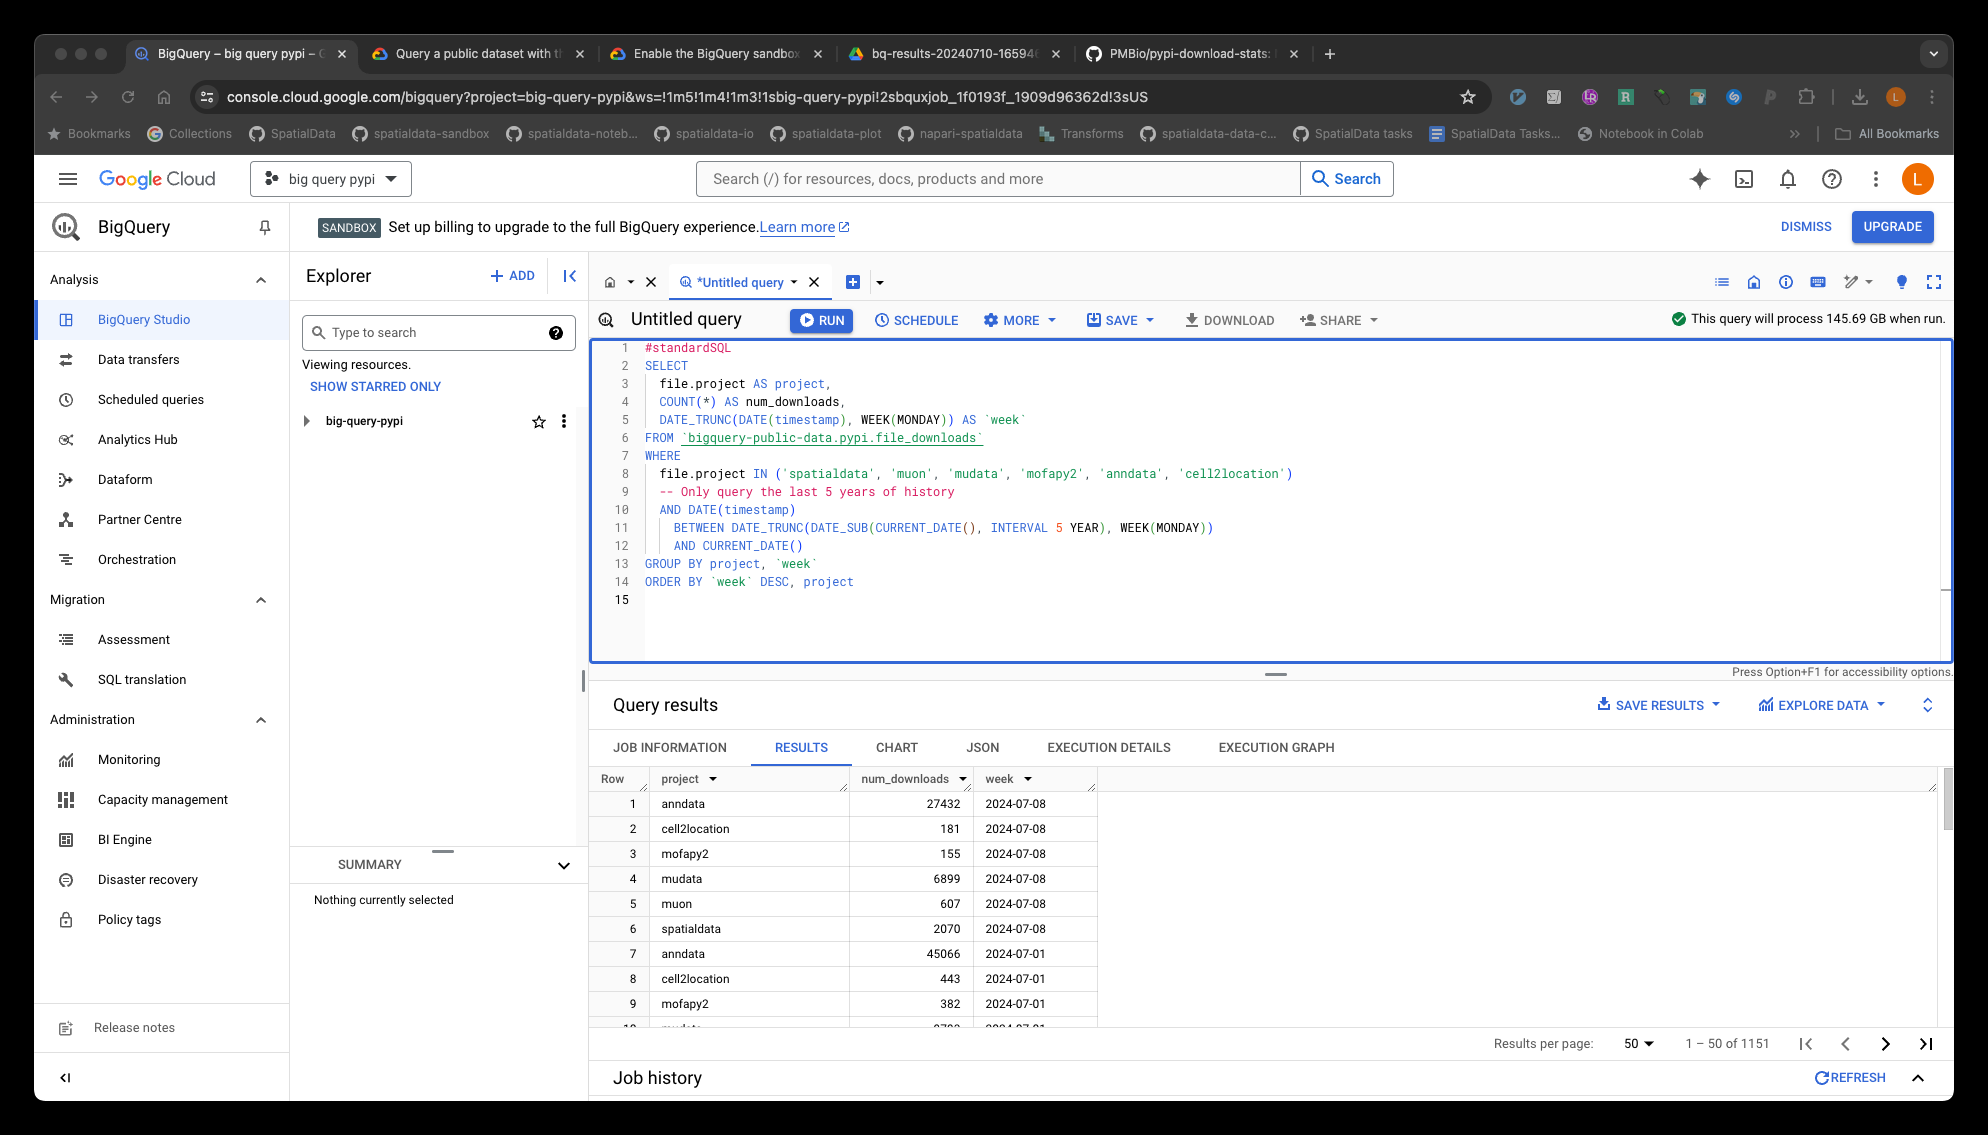

## Plot the data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.backends.backend_pdf import PdfPages

# Load the CSV file
file_path = 'data.csv'
data = pd.read_csv(file_path)

# Convert 'week' column to datetime
data['week'] = pd.to_datetime(data['week'])

# Get the unique projects
projects = data['project'].unique()
projects

array(['anndata', 'cell2location', 'mofapy2', 'mudata', 'muon',
       'spatialdata'], dtype=object)

In [13]:
# one anndata row needs to be removed (problem with the data)
CUTOFF = 100000
filtered_data = data[data['num_downloads'] > CUTOFF]
print(filtered_data)

data = data[data['num_downloads'] <= CUTOFF]

Empty DataFrame
Columns: [project, num_downloads, week]
Index: []


In [15]:
# remove the current week since the data is incomplete until the week is over)
data = data[data['week'] != data['week'].max()]

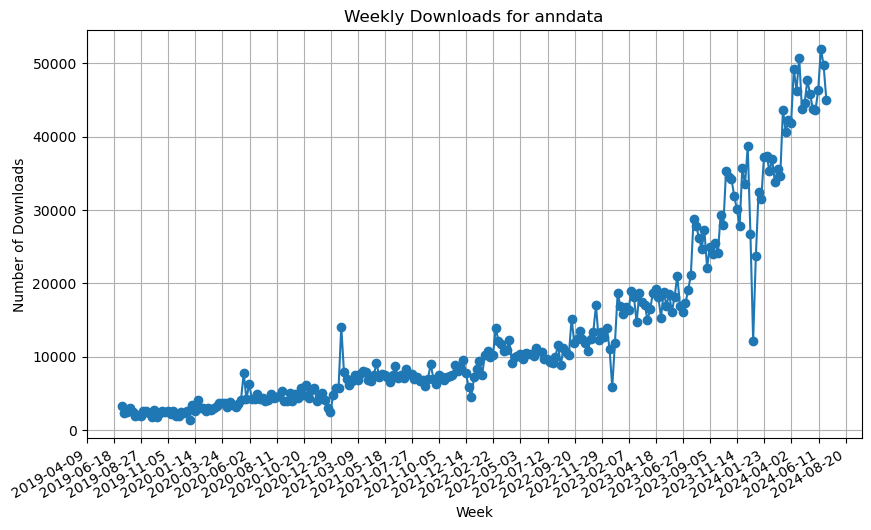

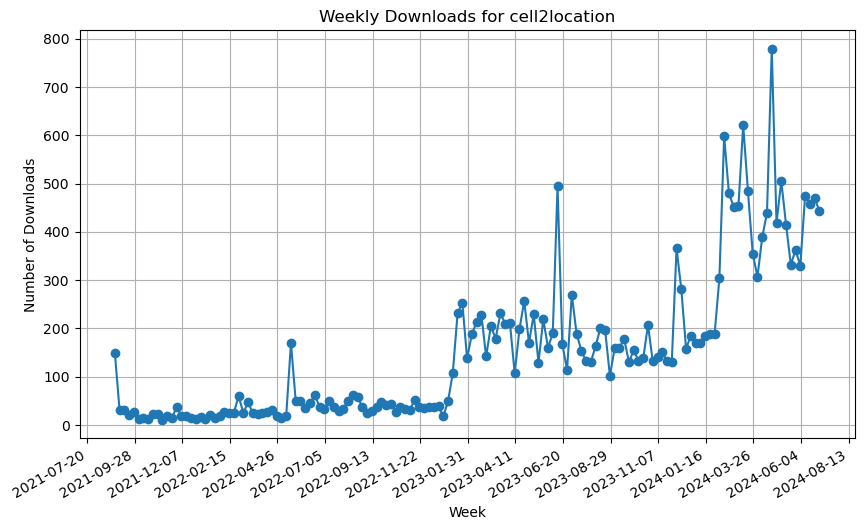

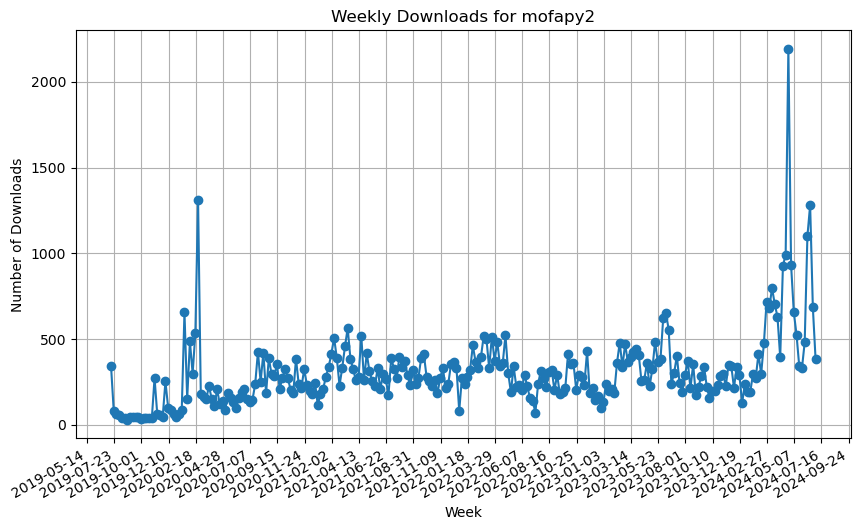

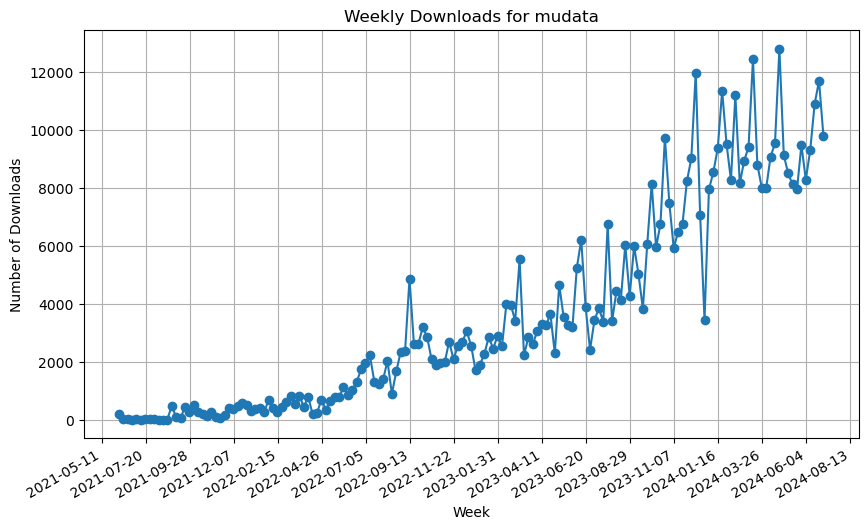

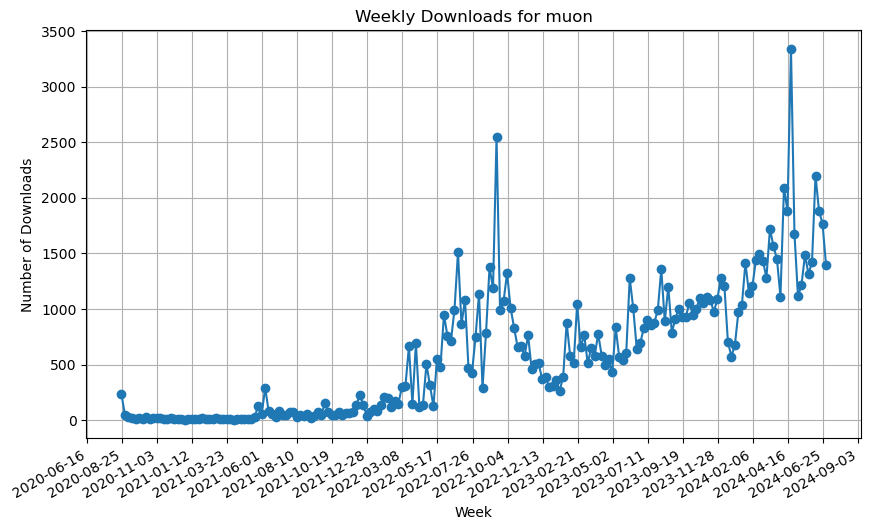

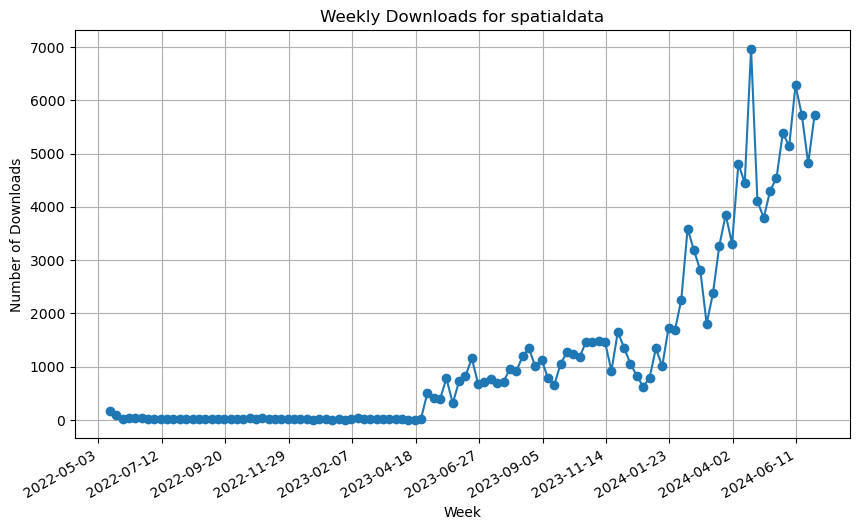

'weekly_downloads_plots.pdf'

In [17]:
# Create a PDF with plots for each project
pdf_path = 'weekly_downloads_plots.pdf'
with PdfPages(pdf_path) as pdf:
    for project in projects:
        project_data = data[data['project'] == project]
        plt.figure(figsize=(10, 6))
        plt.plot(project_data['week'], project_data['num_downloads'], marker='o')
        plt.title(f'Weekly Downloads for {project}')
        plt.xlabel('Week')
        plt.ylabel('Number of Downloads')
        plt.grid(True)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
        plt.gcf().autofmt_xdate()
        pdf.savefig()
        plt.show()
        plt.close()

pdf_path